# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [274]:
pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [275]:
#pip install opencv-python

In [276]:
import os
import imageio
import datetime
import os
import math
import cv2 as cv

We set the random seed so that the results don't vary drastically.

In [277]:
import numpy as np
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from keras.layers import Dropout
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [278]:
train_doc = np.random.permutation(open('D:/030_Neural Networks Project - Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('D:/030_Neural Networks Project - Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 20

In [279]:
train_doc

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
       'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180907_1

In [280]:
val_doc

array(['WIN_20180926_17_24_20_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180907_15_54_30_Pro_Thumbs Up_new;Thumbs Up_new;4\n',
       'WIN_20180926_17_08_11_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_16_16_48_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180907_16_33_15_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
       'WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180907_16_25_44_Pro_Stop Gesture_new;Stop Gesture_new;2\n',
       'WIN_20180926_17_05_38_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180907_15_55_06_Pro_Right Swipe_new;Right Swipe_new;1\n',
       'WIN_20180926_16_57_50_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180926_17_24_12_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180907_15_57_43_Pro_Right Swipe_new;Right Swipe_new;1\n',
       'WIN_20180926_17_05_38_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [281]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [i for i in range(0,30)]#create a list of image numbers you want to use for a particular video
    x = len(img_idx) #x is the number of images you use for each video
    y = 128 #(y,z) is the final size of the input images and 3 is the number of channels RGB
    z = 128 #(y,z) is the final size of the input images and 3 is the  number of channels RGB
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  math.floor(len(t)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    if image.shape[0] != image.shape[1]:
                        image=image[0:120,20:140]
                        
                    # Resizing the image
                    image = cv.resize(image, (y, z), interpolation=cv.INTER_AREA)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,0],5))#normalise and feed in the image
                    

                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    
        # write the code for the remaining data points which are left after full batches
        #Code for remaining values in batch
         # write the code for the remaining data points which are left after full batches
        #Code for remaining values in batch
        total_folder_processed = num_batches * batch_size # Finding total images procees
        remaining_batch_size = len(folder_list) -  total_folder_processed # finding remaining images to process
        batch_data = np.zeros((remaining_batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output
            
        for folder in range(remaining_batch_size): # iterate over remaining images
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*remaining_batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                image = imageio.imread(source_path+'/'+ t[folder + (batch*remaining_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                # Cropping non symmetric frames
                if image.shape[0] != image.shape[1]:
                    image=image[0:120,20:140]

                # Resizing the image
                image = cv.resize(image, (y, z), interpolation=cv.INTER_AREA)

                batch_data[folder,idx,:,:,0] = image[:,:,0] - np.percentile(image[:,:,0],5) / (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                batch_data[folder,idx,:,:,1] = image[:,:,1] - np.percentile(image[:,:,1],5) / (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image
                batch_data[folder,idx,:,:,2] = image[:,:,2] - np.percentile(image[:,:,2],5) / (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,0],5)) #normalise and feed in the image

            batch_labels[folder, int(t[folder + (batch*remaining_batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [282]:
curr_dt_time = datetime.datetime.now()
train_path = 'D:/030_Neural Networks Project - Gesture Recognition/Project_data/train'
val_path = 'D:/030_Neural Networks Project - Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [283]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.layers.convolutional import  Conv2D,MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM, Input, MaxPool3D,ZeroPadding3D

import matplotlib.pyplot as plt

from keras.optimizers import Adam
optimiser = Adam(0.001) #write your optimizer

In [284]:
input_shape = (len([i for i in range(0,30)]),128,128,3)
no_classes = 5

### CNN_3D

#### model_cnn_3d_1

In [285]:
model_cnn_3d_1 = Sequential()
#Layer 1
model_cnn_3d_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model_cnn_3d_1.add(BatchNormalization())
model_cnn_3d_1.add(Activation('relu'))
model_cnn_3d_1.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 2
model_cnn_3d_1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_cnn_3d_1.add(BatchNormalization())
model_cnn_3d_1.add(Activation('relu'))
model_cnn_3d_1.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model_cnn_3d_1.add(Flatten())

model_cnn_3d_1.add(Dense(256, activation='relu'))

model_cnn_3d_1.add(Dense(128, activation='relu'))
#softmax layer
model_cnn_3d_1.add(Dense(no_classes, activation='softmax'))

model_cnn_3d_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_3d_1.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization_61 (Bat  (None, 30, 128, 128, 8)  32        
 chNormalization)                                                
                                                                 
 activation_76 (Activation)  (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d_74 (MaxPoolin  (None, 15, 64, 64, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_77 (Conv3D)          (None, 15, 64, 64, 16)    3472      
                                                                 
 batch_normalization_62 (Bat  (None, 15, 64, 64, 16) 

In [287]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_cnn_3d_1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_cnn_3d_1_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_cnn_3d_1_history = model_cnn_3d_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 42.1439 - categorical_accuracy: 0.3816 Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_cnn_3d_1_init_2022-11-1517_16_58.016014\model_cnn_3d_1_-00001-42.14392-0.38160-121.01675-0.28000.h5
34/34 [==============================] - 351s 10s/step - loss: 42.1439 - categorical_accuracy: 0.3816 - val_loss: 121.0167 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 3.8734 - categorical_accuracy: 0.7722 
Epoch 2: saving model to model_cnn_3d_1_init_2022-11-1517_16_58.016014\model_cnn_3d_1_-00002-3.87342-0.77225-16.12397-0.58000.h5
34/34 [==============================] - 354s 10s/step - loss: 3.8734 - categorical_accuracy: 0.7722 - val_loss: 16.1240 - val_categorical_accurac

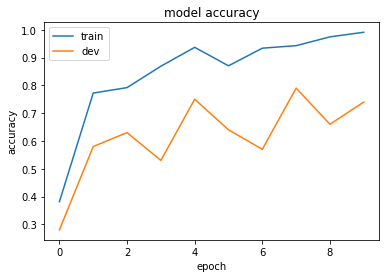

In [288]:
 # summarize history for accuracy
plt.plot(model_cnn_3d_1_history.history['categorical_accuracy']) # Get 
plt.plot(model_cnn_3d_1_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

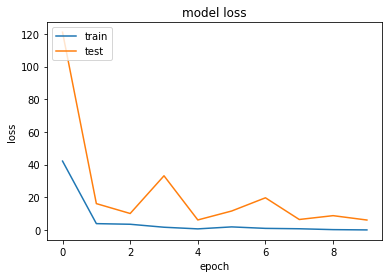

In [289]:
 # summarize history for loss
plt.plot(model_cnn_3d_1_history.history['loss'])
plt.plot(model_cnn_3d_1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_cnn_3d_2

In [291]:
model_cnn_3d_2 = Sequential()
#Layer 1
model_cnn_3d_2.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model_cnn_3d_2.add(BatchNormalization())
model_cnn_3d_2.add(Activation('relu'))
model_cnn_3d_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 2
model_cnn_3d_2.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_cnn_3d_2.add(BatchNormalization())
model_cnn_3d_2.add(Activation('relu'))
model_cnn_3d_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 3
model_cnn_3d_2.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_cnn_3d_2.add(BatchNormalization())
model_cnn_3d_2.add(Activation('relu'))
model_cnn_3d_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 4
model_cnn_3d_2.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_cnn_3d_2.add(Activation('relu'))
model_cnn_3d_2.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model_cnn_3d_2.add(Flatten())

model_cnn_3d_2.add(Dense(256, activation='relu'))

model_cnn_3d_2.add(Dense(128, activation='relu'))

#softmax layer
model_cnn_3d_2.add(Dense(no_classes, activation='softmax'))

model_cnn_3d_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_3d_2.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_82 (Conv3D)          (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization_66 (Bat  (None, 30, 128, 128, 8)  32        
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d_79 (MaxPoolin  (None, 15, 64, 64, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_83 (Conv3D)          (None, 15, 64, 64, 16)    3472      
                                                                 
 batch_normalization_67 (Bat  (None, 15, 64, 64, 16) 

In [292]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_cnn_3d_2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_cnn_3d_2-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_cnn_3d_2_history = model_cnn_3d_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20


C:\Users\SERGIO~1\AppData\Local\Temp/ipykernel_17580/2810200742.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_cnn_3d_2_history = model_cnn_3d_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.4787 - categorical_accuracy: 0.2036Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_cnn_3d_2_init_2022-11-1517_16_58.016014\model_cnn_3d_2-00001-2.47870-0.20362-1.60891-0.23000.h5
34/34 [==============================] - 347s 10s/step - loss: 2.4787 - categorical_accuracy: 0.2036 - val_loss: 1.6089 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.6095 - categorical_accuracy: 0.1991 
Epoch 2: saving model to model_cnn_3d_2_init_2022-11-1517_16_58.016014\model_cnn_3d_2-00002-1.60952-0.19910-1.60883-0.21000.h5
34/34 [==============================] - 350s 10s/step - loss: 1.6095 - categorical_accuracy: 0.1991 - val_loss: 1.6088 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.6098 - categorical_accur

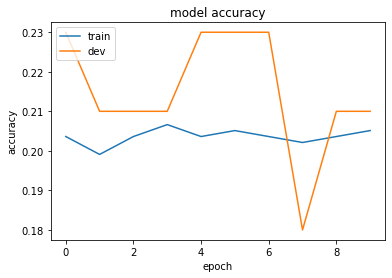

In [293]:
 # summarize history for accuracy
plt.plot(model_cnn_3d_2_history.history['categorical_accuracy']) # Get 
plt.plot(model_cnn_3d_2_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

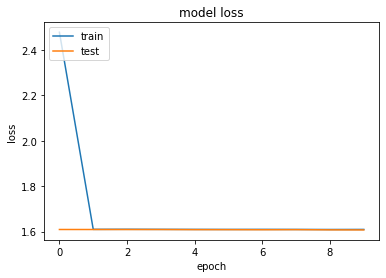

In [295]:
 # summarize history for loss
plt.plot(model_cnn_3d_2_history.history['loss'])
plt.plot(model_cnn_3d_2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_cnn_3d_3

In [297]:
model_cnn_3d_3 = Sequential()
#Layer 1
model_cnn_3d_3.add(Conv3D(8, kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model_cnn_3d_3.add(BatchNormalization())
model_cnn_3d_3.add(Activation('relu'))
model_cnn_3d_3.add(Dropout(0.25))
model_cnn_3d_3.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 2
model_cnn_3d_3.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model_cnn_3d_3.add(BatchNormalization())
model_cnn_3d_3.add(Activation('relu'))
model_cnn_3d_3.add(Dropout(0.25))
model_cnn_3d_3.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 3
model_cnn_3d_3.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
model_cnn_3d_3.add(BatchNormalization())
model_cnn_3d_3.add(Activation('relu'))
model_cnn_3d_3.add(Dropout(0.25))
model_cnn_3d_3.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer 4
model_cnn_3d_3.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
model_cnn_3d_3.add(Activation('relu'))
model_cnn_3d_3.add(Dropout(0.25))
model_cnn_3d_3.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
model_cnn_3d_3.add(Flatten())

model_cnn_3d_3.add(Dense(256, activation='relu'))
model_cnn_3d_3.add(Dropout(0.5))

model_cnn_3d_3.add(Dense(128, activation='relu'))
model_cnn_3d_3.add(Dropout(0.5))

#softmax layer
model_cnn_3d_3.add(Dense(no_classes, activation='softmax'))


model_cnn_3d_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_cnn_3d_3.summary())

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_87 (Conv3D)          (None, 30, 128, 128, 8)   656       
                                                                 
 batch_normalization_70 (Bat  (None, 30, 128, 128, 8)  32        
 chNormalization)                                                
                                                                 
 activation_87 (Activation)  (None, 30, 128, 128, 8)   0         
                                                                 
 dropout (Dropout)           (None, 30, 128, 128, 8)   0         
                                                                 
 max_pooling3d_83 (MaxPoolin  (None, 15, 64, 64, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_88 (Conv3D)          (None, 15, 64, 64, 16)  

In [298]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_cnn_3d_3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_cnn_3d_3-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_cnn_3d_3_history = model_cnn_3d_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20


C:\Users\SERGIO~1\AppData\Local\Temp/ipykernel_17580/192082941.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_cnn_3d_3_history = model_cnn_3d_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.4363 - categorical_accuracy: 0.2760 Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_cnn_3d_3_init_2022-11-1517_16_58.016014\model_cnn_3d_3-00001-2.43627-0.27602-4.51484-0.18000.h5
34/34 [==============================] - 368s 11s/step - loss: 2.4363 - categorical_accuracy: 0.2760 - val_loss: 4.5148 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5174 - categorical_accuracy: 0.3499 
Epoch 2: saving model to model_cnn_3d_3_init_2022-11-1517_16_58.016014\model_cnn_3d_3-00002-1.51739-0.34992-1.52308-0.31000.h5
34/34 [==============================] - 369s 11s/step - loss: 1.5174 - categorical_accuracy: 0.3499 - val_loss: 1.5231 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.3452 - categorical_accu

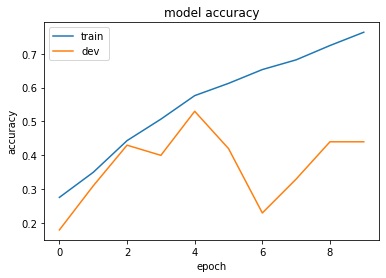

In [299]:
 # summarize history for accuracy
plt.plot(model_cnn_3d_3_history.history['categorical_accuracy']) # Get 
plt.plot(model_cnn_3d_3_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

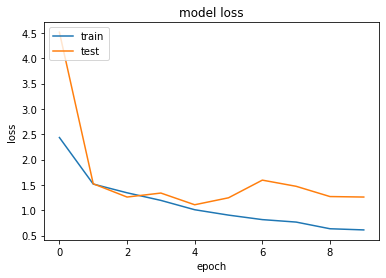

In [300]:
 # summarize history for loss
plt.plot(model_cnn_3d_3_history.history['loss'])
plt.plot(model_cnn_3d_3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN_LSTM

#### model_ccn_lstm_1

In [304]:
model_ccn_lstm_1 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_lstm_1.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_lstm_1.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_1.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_lstm_1.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_1.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_lstm_1.add(TimeDistributed(BatchNormalization()))

model_ccn_lstm_1.add(TimeDistributed(Flatten()))

model_ccn_lstm_1.add(Dense(128, activation='relu'))

## using LSTM -> RNN model  and softmax -> last layer.
model_ccn_lstm_1.add(LSTM(128, return_sequences=False))
model_ccn_lstm_1.add(Dense(5, activation='softmax'))

model_ccn_lstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_lstm_1.summary())

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 30, 64, 64, 8)    224       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 4, 4, 32)   

In [305]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_lstm_1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_lstm_1_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_lstm_1_history = model_ccn_lstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.5783 - categorical_accuracy: 0.2926Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_lstm_1_init_2022-11-1517_16_58.016014\model_ccn_lstm_1_-00001-1.57826-0.29261-1.69807-0.26000.h5
34/34 [==============================] - 100s 2s/step - loss: 1.5783 - categorical_accuracy: 0.2926 - val_loss: 1.6981 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.4669 - categorical_accuracy: 0.4163
Epoch 2: saving model to model_ccn_lstm_1_init_2022-11-1517_16_58.016014\model_ccn_lstm_1_-00002-1.46694-0.41629-1.67174-0.28000.h5
34/34 [==============================] - 80s 2s/step - loss: 1.4669 - categorical_accuracy: 0.4163 - val_loss: 1.6717 - val_categorical_accuracy:

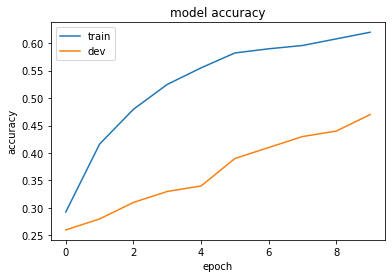

In [306]:
 # summarize history for accuracy
plt.plot(model_ccn_lstm_1_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_lstm_1_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

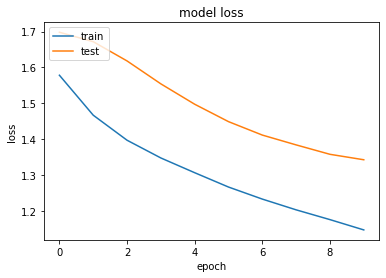

In [310]:
 # summarize history for loss
plt.plot(model_ccn_lstm_1_history.history['loss'])
plt.plot(model_ccn_lstm_1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_ccn_lstm_2

In [308]:
model_ccn_lstm_2 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_lstm_2.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_lstm_2.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_lstm_2.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

# layer 4
# input, with 64 convolutions
model_ccn_lstm_2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_lstm_2.add(TimeDistributed(BatchNormalization()))

model_ccn_lstm_2.add(TimeDistributed(Flatten()))

model_ccn_lstm_2.add(Dense(128, activation='relu'))

## using LSTM -> RNN model  and softmax -> last layer.
model_ccn_lstm_2.add(LSTM(128, return_sequences=False))
model_ccn_lstm_2.add(Dense(5, activation='softmax'))

model_ccn_lstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_lstm_2.summary())

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 4, 4, 32)   

In [309]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_lstm_2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_lstm_2_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_lstm_2_history = model_ccn_lstm_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6665 - categorical_accuracy: 0.1719Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_lstm_2_init_2022-11-1517_16_58.016014\model_ccn_lstm_2_-00001-1.66647-0.17195-1.65297-0.15000.h5
34/34 [==============================] - 150s 4s/step - loss: 1.6665 - categorical_accuracy: 0.1719 - val_loss: 1.6530 - val_categorical_accuracy: 0.1500 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5349 - categorical_accuracy: 0.3303
Epoch 2: saving model to model_ccn_lstm_2_init_2022-11-1517_16_58.016014\model_ccn_lstm_2_-00002-1.53494-0.33032-1.66968-0.20000.h5
34/34 [==============================] - 146s 4s/step - loss: 1.5349 - categorical_accuracy: 0.3303 - val_loss: 1.6697 - val_categorical_accuracy

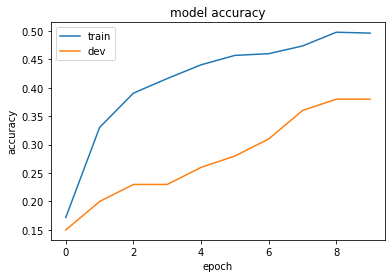

In [311]:
 # summarize history for accuracy
plt.plot(model_ccn_lstm_2_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_lstm_2_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

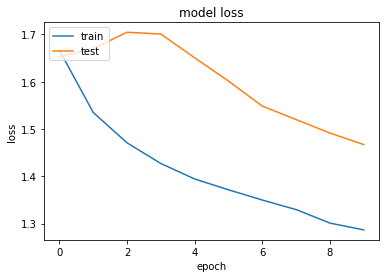

In [312]:
 # summarize history for loss
plt.plot(model_ccn_lstm_2_history.history['loss'])
plt.plot(model_ccn_lstm_2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_ccn_lstm_3

In [313]:
model_ccn_lstm_3 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_lstm_3.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_lstm_3.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_lstm_3.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

# layer 4
# input, with 64 convolutions
model_ccn_lstm_3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_lstm_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_lstm_3.add(TimeDistributed(BatchNormalization()))
model_ccn_lstm_3.add(Dropout(0.5))

model_ccn_lstm_3.add(TimeDistributed(Flatten()))

model_ccn_lstm_3.add(Dense(128, activation='relu'))
model_ccn_lstm_3.add(Dropout(0.5))
model_ccn_lstm_3.add(Dense(64, activation='relu'))
model_ccn_lstm_3.add(Dropout(0.5))

## using LSTM -> RNN model  and softmax -> last layer.
model_ccn_lstm_3.add(LSTM(128, return_sequences=False))
model_ccn_lstm_3.add(Dense(5, activation='softmax'))


model_ccn_lstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_lstm_3.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 30, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 30, 4, 4, 32)   

In [314]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_lstm_3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_lstm_3_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_lstm_3_history = model_ccn_lstm_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6254 - categorical_accuracy: 0.1900Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_lstm_3_init_2022-11-1517_16_58.016014\model_ccn_lstm_3_-00001-1.62543-0.19005-1.62875-0.26000.h5
34/34 [==============================] - 88s 3s/step - loss: 1.6254 - categorical_accuracy: 0.1900 - val_loss: 1.6288 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5891 - categorical_accuracy: 0.2594
Epoch 2: saving model to model_ccn_lstm_3_init_2022-11-1517_16_58.016014\model_ccn_lstm_3_-00002-1.58906-0.25943-1.62550-0.24000.h5
34/34 [==============================] - 85s 3s/step - loss: 1.5891 - categorical_accuracy: 0.2594 - val_loss: 1.6255 - val_categorical_accuracy: 

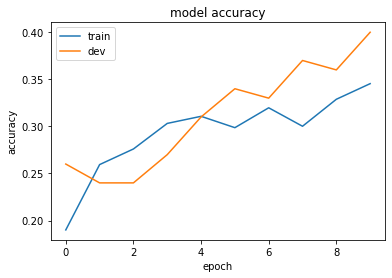

In [315]:
 # summarize history for accuracy
plt.plot(model_ccn_lstm_3_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_lstm_3_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

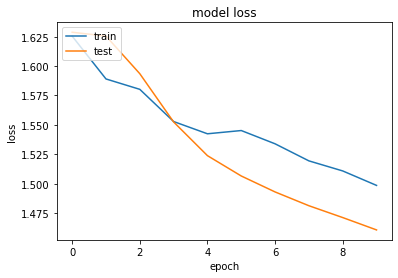

In [316]:
 # summarize history for loss
plt.plot(model_ccn_lstm_3_history.history['loss'])
plt.plot(model_ccn_lstm_3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### CNN_GRU

#### model_ccn_gru_1

In [317]:
 model_ccn_gru_1 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_gru_1.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_gru_1.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_1.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_gru_1.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_1.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_gru_1.add(TimeDistributed(BatchNormalization()))

model_ccn_gru_1.add(TimeDistributed(Flatten()))

model_ccn_gru_1.add(Dense(128, activation='relu'))

## using GRU -> RNN model  and softmax -> last layer.
model_ccn_gru_1.add(GRU(128, return_sequences=False))
model_ccn_gru_1.add(Dense(5, activation='softmax'))

model_ccn_gru_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_gru_1.summary())

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_34 (TimeDi  (None, 30, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 30, 4, 4, 32)   

In [318]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_gru_1_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_gru_1_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_gru_1_history = model_ccn_gru_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.7146 - categorical_accuracy: 0.2459Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_gru_1_init_2022-11-1517_16_58.016014\model_ccn_gru_1_-00001-1.71460-0.24585-1.74585-0.23000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.7146 - categorical_accuracy: 0.2459 - val_loss: 1.7459 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5151 - categorical_accuracy: 0.3273
Epoch 2: saving model to model_ccn_gru_1_init_2022-11-1517_16_58.016014\model_ccn_gru_1_-00002-1.51511-0.32730-1.79780-0.27000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.5151 - categorical_accuracy: 0.3273 - val_loss: 1.7978 - val_categorical_accuracy: 0.27

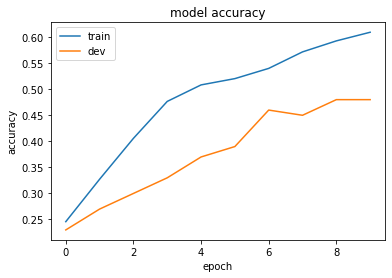

In [319]:
 # summarize history for accuracy
plt.plot(model_ccn_gru_1_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_gru_1_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

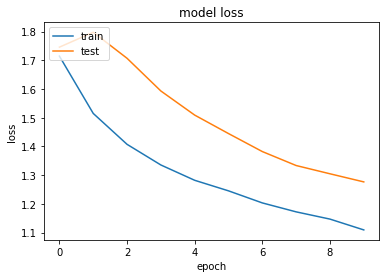

In [320]:
 # summarize history for loss
plt.plot(model_ccn_gru_1_history.history['loss'])
plt.plot(model_ccn_gru_1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_ccn_gru_2

In [321]:
model_ccn_gru_2 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_gru_2.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_gru_2.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_gru_2.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

# layer 4
# input, with 64 convolutions
model_ccn_gru_2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_2.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_gru_2.add(TimeDistributed(BatchNormalization()))

model_ccn_gru_2.add(TimeDistributed(Flatten()))

model_ccn_gru_2.add(Dense(128, activation='relu'))

## using GRU -> RNN model  and softmax -> last layer.
model_ccn_gru_2.add(GRU(128, return_sequences=False))
model_ccn_gru_2.add(Dense(5, activation='softmax'))

model_ccn_gru_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_gru_2.summary())

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_41 (TimeDi  (None, 30, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 30, 4, 4, 32)   

In [322]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_gru_2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_gru_2_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_gru_2_history = model_ccn_gru_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6417 - categorical_accuracy: 0.2172Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_gru_2_init_2022-11-1517_16_58.016014\model_ccn_gru_2_-00001-1.64172-0.21719-1.90548-0.19000.h5
34/34 [==============================] - 94s 3s/step - loss: 1.6417 - categorical_accuracy: 0.2172 - val_loss: 1.9055 - val_categorical_accuracy: 0.1900 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.5358 - categorical_accuracy: 0.3228
Epoch 2: saving model to model_ccn_gru_2_init_2022-11-1517_16_58.016014\model_ccn_gru_2_-00002-1.53576-0.32278-1.72297-0.26000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.5358 - categorical_accuracy: 0.3228 - val_loss: 1.7230 - val_categorical_accuracy: 0.26

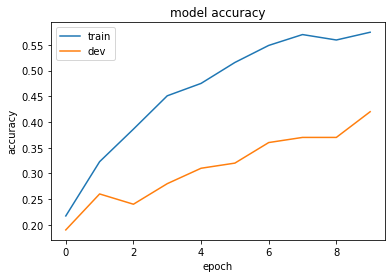

In [323]:
 # summarize history for accuracy
plt.plot(model_ccn_gru_2_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_gru_2_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

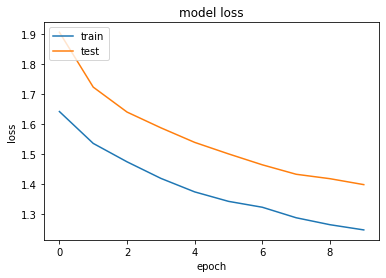

In [324]:
 # summarize history for loss
plt.plot(model_ccn_gru_2_history.history['loss'])
plt.plot(model_ccn_gru_2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### model_ccn_gru_3

In [330]:
model_ccn_gru_3 = Sequential()
# layer 1
# input, with 8 convolutions with image (128, 128, 3) shape
model_ccn_gru_3.add(TimeDistributed(Conv2D(8, (3,3), padding='same', strides=(2,2), activation='relu'),input_shape = input_shape))
# layer 2
# input, with 16 convolutions
model_ccn_gru_3.add(TimeDistributed(Conv2D(16, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))
# layer 3
# input, with 32 convolutions
model_ccn_gru_3.add(TimeDistributed(Conv2D(32, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

# layer 4
# input, with 64 convolutions
model_ccn_gru_3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', strides=(2,2), activation='relu')))
model_ccn_gru_3.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

model_ccn_gru_3.add(TimeDistributed(BatchNormalization()))
model_ccn_gru_3.add(Dropout(0.5))

model_ccn_gru_3.add(TimeDistributed(Flatten()))

model_ccn_gru_3.add(Dense(128, activation='relu'))
model_ccn_gru_3.add(Dropout(0.5))
model_ccn_gru_3.add(Dense(64, activation='relu'))
model_ccn_gru_3.add(Dropout(0.5))

## using GRU -> RNN model  and softmax -> last layer.
model_ccn_gru_3.add(GRU(128, return_sequences=False))
model_ccn_gru_3.add(Dense(5, activation='softmax'))


model_ccn_gru_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_ccn_gru_3.summary())

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_68 (TimeDi  (None, 30, 64, 64, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_69 (TimeDi  (None, 30, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_70 (TimeDi  (None, 30, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 30, 8, 8, 32)     4640      
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 30, 4, 4, 32)   

In [331]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_ccn_gru_3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model_ccn_gru_3_-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',epsilon=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model_ccn_gru_3_history = model_ccn_gru_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 1.6740 - categorical_accuracy: 0.1765Source path =  D:/030_Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_ccn_gru_3_init_2022-11-1517_16_58.016014\model_ccn_gru_3_-00001-1.67399-0.17647-1.97135-0.23000.h5
34/34 [==============================] - 95s 3s/step - loss: 1.6740 - categorical_accuracy: 0.1765 - val_loss: 1.9713 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-05
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.6326 - categorical_accuracy: 0.2097
Epoch 2: saving model to model_ccn_gru_3_init_2022-11-1517_16_58.016014\model_ccn_gru_3_-00002-1.63257-0.20965-1.89165-0.22000.h5
34/34 [==============================] - 96s 3s/step - loss: 1.6326 - categorical_accuracy: 0.2097 - val_loss: 1.8917 - val_categorical_accuracy: 0.22

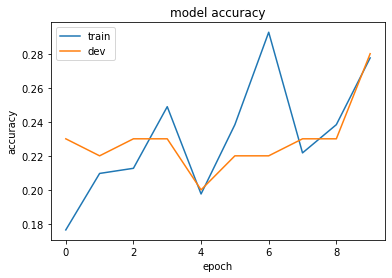

In [332]:
 # summarize history for accuracy
plt.plot(model_ccn_gru_3_history.history['categorical_accuracy']) # Get 
plt.plot(model_ccn_gru_3_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

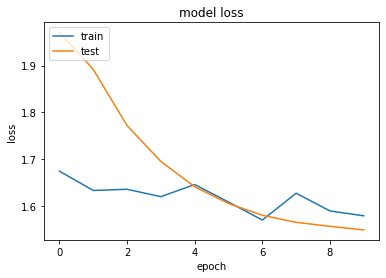

In [333]:
 # summarize history for loss
plt.plot(model_ccn_gru_3_history.history['loss'])
plt.plot(model_ccn_gru_3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()